# Lab 1 : Visualization and Data Processing

## Group 4 :  Simerpreet Reddy, Rudranil Mitra, Samuel VonPaays Soh, Kristi Herman

---
## <font color='darkgreen'> Business Understanding </font>

The source selected for this analysis is a Craigslist used car listings dataset from Kaggle:  https://www.kaggle.com/austinreese/craigslist-carstrucks-data<br>.  The author of this dataset used web scraping algorithms to scrape the information from Craigslist. 


#### <font color='green'>Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)</font>
The purpose of this dataset is to collect data for all used cars and trucks for sale in the U.S. that are listed on Craigslist regional sites.  This dataset can be used to model and predict used car prices or prices can be categorized into groups and the price range categories can be predicted. 


#### <font color='green'>Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? </font>

We will know that we have mined useful knowledge if we are able to come up with a good prediction of used car prices and a classifier for price range predictions. In other words, a good model will be able to find relationships among the predictors and the response variables.  

#### <font color='green'>How would you measure the effectiveness of a good prediction algorithm? Be specific. </font>

Our goal is to run both both regression and classification algorithms on this dataset. For the regression problem to predict car prices, RMSE along with k-fold cross validation will be used to determine the effectiveness of the prediction. For the classification problem, k-fold cross validation with accuracy, precision, recall, True Positive Rate, and False Positive Rate will be used to measure the effectiveness of the prediction model. The value for 'k' in cross validation will be determined through hyperparameter tuning during the model building process.

## Data Meaning Type

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.*



In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [2]:
#import vehicle dataset
orig_df = pd.read_csv('data/vehicles.csv') 

The initial dataset contained 458,213 rows with 26 fields.

In [25]:
# Copy original file to car_df, keep the original dataset in case it is needed. 
# This step will avoid reloading the large file
car_df = orig_df.copy()
#info
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
Unnamed: 0      458213 non-null int64
id              458213 non-null int64
url             458213 non-null object
region          458213 non-null object
region_url      458213 non-null object
price           458213 non-null int64
year            457163 non-null float64
manufacturer    439993 non-null object
model           453367 non-null object
condition       265273 non-null object
cylinders       287073 non-null object
fuel            454976 non-null object
odometer        402910 non-null float64
title_status    455636 non-null object
transmission    455771 non-null object
VIN             270664 non-null object
drive           324025 non-null object
size            136865 non-null object
type            345475 non-null object
paint_color     317370 non-null object
image_url       458185 non-null object
description     458143 non-null object
state           458213 non-null 

These fields were immediately dropped since they wouldn't be used for prediction and they weren't needed for other purposes.

In [30]:
#drop extra ID fields, URL fields, region fields, and description
car_df = car_df.drop(columns=['id','Unnamed: 0','url','region_url','description','size','region'])

This is a more detailed description of the fields that will be used for explanatory and response variables.

In [26]:
#import data field descriptions
desc_df = pd.read_csv('data/fields.csv') 
pd.set_option('display.max_colwidth', -1)
desc_df

,"Field,Description,Type"
0,"price,The price of the used car in USD from 0 - 3.5 billion,integer"
1,"year,The year the car was made from 1900 - 2021,float"
2,"manufacturer,""The manufacturer of the car, e.g., honda or jeep. There are 44 unique manufacturers. "",object"
3,"model,""The model of the car, e.g. f150, malibu, or focus. There are 31,521 unique models."",object"
4,"condition,""The condition of the car with these values: 'salvage', 'fair', 'good', 'excellent', 'like new',' new'"",object"
5,"cylinders,Number of cylinders ranging from 3 - 12 as well as an 'other' category.,object"
6,"fuel,""Type of fuel with these values: 'gas', 'diesel', 'other', 'hybrid', 'electric'"",object"
7,"odometer,Mileage recorded,float"
8,"title_status,'Indicates what the title_status of the car is: 'clean', 'lien', 'missing', 'salvage', 'rebuilt', 'parts only', obj"
9,"transmission,""Type of transmission: 'other', 'automatic', 'manual'"",object"


## Data Quality
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods

### Missing values

The first data quality issue to address was the significant number of missing values. 

In [35]:
#get n/a values
car_df.isna().sum()

price           0     
year            145   
manufacturer    18220 
model           3837  
condition       192940
cylinders       80402 
fuel            415   
odometer        55303 
title_status    2577  
transmission    1940  
drive           92235 
type            112738
paint_color     140843
image_url       28    
state           0     
lat             7448  
long            7448  
posting_date    28    
dtype: int64

Some data such as manufacturer, model, transmission, fuel, etc. could be attained from the Department of Transportation using the VIN number.  A scraper was built to retrieve the data.  The scraper code is here:  < put in link >.  Once the data was retrieved it was exported to a separate csv, then imported and merged into car_df.

In [28]:
#import VIN dataset
vin_df  = pd.read_csv('data/vin_data.csv',sep='|', encoding='latin-1')

In [29]:
# Merge the VIN dataset with the original dataset
# With this merge we are able to fill out many missing values in the original dataset 

# Creating a SK Learn Transformer template, will be useful later to generate a 
# data cleaning pipeline 
class MergeTransform(BaseEstimator, TransformerMixin):
    def __init__(self,original_dataset,column_map,columns_to_drop,join_column):
        self.original_dataset = original_dataset
        self.column_map = column_map
        self.columns_to_drop = columns_to_drop
        self.join_column = join_column
    #
    def fit(self, X, y = None):
        return self
    #
    def transform(self, X, y = None):
        #
        X = X.drop_duplicates(['VIN'])
        #
        merged_dataset = pd.merge(self.original_dataset, X, how='left',on=self.join_column)
        #
        for k,v in self.column_map:
            merged_dataset[k].fillna(merged_dataset[v],inplace=True)
        #
        merged_dataset.drop(self.columns_to_drop,axis = 1, inplace = True)
        merged_dataset['cylinders']=merged_dataset['cylinders'].replace({'cylinders':''},regex=True)
        #
        return merged_dataset
    
# The datasets will be joined on VIN
join_col = ['VIN']

# These are the columns that are being clean. The column on the left is the from the cars dataset. These columns
# have null values and need to be replaced from the VIN dataset
column_transform_map = [['cylinders', 'EngineCylinders'],
                        ['year', 'ModelYear'],
                        ['fuel', 'FuelTypePrimary'],
                        ['drive', 'DriveType'],
                        ['transmission', 'TransmissionStyle'],
                        ['model', 'Model']]

# These are additional columns from the VIN dataset an can be dropped after the merge 
columns_to_drop = ['DriveType', 'EngineCylinders', 'EngineManufacturer', 'EngineModel', 'Make', 'Manufacturer', 'Model', 'ModelYear', 'PlantCompanyName', 'TransmissionSpeeds', 'TransmissionStyle', 'FuelTypePrimary']

# Create an instance of the transformer
transformer = MergeTransform(car_df, column_transform_map, columns_to_drop, join_col)

# Run the transformer to generate the clean dataset
car_df = transformer.transform(vin_df)    

In [32]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458213 entries, 0 to 458212
Data columns (total 19 columns):
price           458213 non-null int64
year            458068 non-null float64
manufacturer    439993 non-null object
model           454376 non-null object
condition       265273 non-null object
cylinders       377811 non-null object
fuel            457798 non-null object
odometer        402910 non-null float64
title_status    455636 non-null object
transmission    456273 non-null object
VIN             270664 non-null object
drive           365978 non-null object
type            345475 non-null object
paint_color     317370 non-null object
image_url       458185 non-null object
state           458213 non-null object
lat             450765 non-null float64
long            450765 non-null float64
posting_date    458185 non-null object
dtypes: float64(4), int64(1), object(14)
memory usage: 69.9+ MB


In [33]:
#how many nas?
car_df.isna().sum()

price           0     
year            145   
manufacturer    18220 
model           3837  
condition       192940
cylinders       80402 
fuel            415   
odometer        55303 
title_status    2577  
transmission    1940  
VIN             187549
drive           92235 
type            112738
paint_color     140843
image_url       28    
state           0     
lat             7448  
long            7448  
posting_date    28    
dtype: int64

Once the data was merged, the VIN column was dropped since it was no longer needed.

In [34]:
#drop extra ID fields, URL fields, region fields, and description
car_df = car_df.drop(columns=['VIN'])

There was not a way to obtain some of the important variables.  Since these could be important variable, these rows without these were dropped.

In [54]:
#drop rows with n/a for important variables that couldn't be obtained from the dept. of transportation
car_df = car_df[car_df['condition'].notna()]
car_df = car_df[car_df['title_status'].notna()]
car_df = car_df[car_df['drive'].notna()]
car_df = car_df[car_df['fuel'].notna()]
car_df = car_df[car_df['model'].notna()]
car_df = car_df[car_df['manufacturer'].notna()]
car_df['year'].dropna(inplace=True)

In [55]:
car_df.isna().sum()

price            0    
year             0    
manufacturer     0    
model            0    
condition        0    
cylinders        11333
fuel             0    
odometer         14410
title_status     0    
transmission     99   
drive            0    
type             21630
paint_color      34125
image_url        0    
state            0    
lat              1706 
long             1706 
posting_date     0    
condition_new    0    
dtype: int64

Some of the latitude and longitudes were incorrect since this dataaset is U.S. only.  These values were removed and replaced by the latitude and longitude for the states.

In [71]:
#import state latitude and longitude values to use for missing lat/long
state_df = pd.read_csv('data/states.csv') 
state_df.head()

#capitalize the state column in cars_df
car_df['state'] = car_df['state'].str.upper()

#set cells with invalid U.S. lat/long to null.  According to Google, "Lat-long coorditates for cities in United States are in range: Latitude from 19.50139 to 64.85694 and longitude from -161.75583" to -68.01197
car_df.loc[(car_df['long'] <= -162) | (car_df['long'] >= -65),'long'] = np.NaN
car_df.loc[(car_df['lat'] <= 18) | (car_df['lat'] >= 65), 'lat'] = np.NaN

In [72]:
#function to set the latitude and longitude based on state
def geo(idx, st):
    car_df.iloc[idx]['lat'] = (state_df[state_df['state']==st]['latitude']).values[0]
    car_df.iloc[idx]['long'] = (state_df[state_df['state']==st]['longitude']).values[0]

#iterate through the latitude and call the geo function if the latitude is blank    
for index, row in car_df.iterrows():
    if(pd.isnull(row['lat'])):
        geo(index, row['state'])

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


IndexError: single positional indexer is out-of-bounds

In [ ]:
car_df.isna().sum()

### Regrouping data

One of the goals of this project is to predict categorical responses for price range.  A new category field was needed for this.

In [67]:
#Create column price_range to classify price of a car into one of the following groups: ('less than $1000', '$1000 to $5000', '$5000 to $10000','$10000 to $50000', '$50000 to $100000','$100000 to $4000000' etc.)
car_df['price_range$'] = pd.cut(x=car_df['price'], bins=[-1, 1000, 5000,10000,50000, 100000,4000000],labels=['<1K', '1K-5K', '5K-10K','10K-50K', '50k-100K','100K-4MM' ])
car_df['price_range$'].unique()

[10K-50K, 5K-10K, 1K-5K, 50k-100K, <1K, 100K-4MM]
Categories (6, object): [<1K < 1K-5K < 5K-10K < 10K-50K < 50k-100K < 100K-4MM]

The conditions that were similar to each other were grouped together into a condition_new field.

In [59]:
#combine conditions to 4 categories with the following groupings ('good', 'fair'), ('excellent','like new'), 'salvage', 'new' 
conditions = [
    (car_df['condition'] == "good") | (car_df['condition'] == "fair"),
    (car_df['condition'] == "excellent") | (car_df['condition'] == "like new"),
    (car_df['condition'] == "salvage"),
    (car_df['condition'] == "new")
    ]

#new condition categories
values = ['good_fair', 'excellent_likenew', 'salvage', 'new']

#new condition column
car_df['condition_new'] = np.select(conditions, values)
car_df['condition_new'].unique()

array(['good_fair', 'excellent_likenew', 'salvage', 'new'], dtype=object)

In [ ]:
#drop condition field
car_df = car_df.drop(columns=['condition'])

There was some redundancy in the transmission categories.  They were reduced to Automatic, Manual, and Other.

In [60]:
#Group different transmission categories
car_df['transmission'] = car_df['transmission'].fillna('other')
transmission_types = [
    (car_df['transmission'] == "automatic") | (car_df['transmission'] == "Automatic") | (car_df['transmission'] == "Continuously Variable Transmission (CVT)"),
    (car_df['transmission'] == "manual") | (car_df['transmission'] == "Manual/Standard"),
    (car_df['transmission'] == "other")
    ]

#new transmission categories
t_values_types = ['Automatic', 'Manual', 'Other']

#new transmission column
car_df['transmission_new'] = np.select(transmission_types, t_values_types)
car_df['transmission_new'].unique()

array(['Other', 'Automatic', 'Manual', '0'], dtype=object)

Regrouped car types

In [ ]:
#Combine types to: 'sedan', ('wagon','SUV') and call it 'crossover', ('pickup', 'truck'), 'coupe', 'van', 'mini-van', 'convertible', 'hatchback', 'offroad'
car_df['type'] = car_df['type'].fillna('')
car_df = car_df[car_df['type'].isin(['sedan', 'SUV', 'pickup', 'coupe', 'van', 'truck','mini-van', 'wagon', 'convertible', 'hatchback','offroad',''])]

types = [
    (car_df['type'] == "wagon") | (car_df['type'] == "SUV"),
    (car_df['type'] == "pickup") | (car_df['type'] == "truck"),
    (car_df['type'] == "sedan"),
    (car_df['type'] == "coupe"),
     (car_df['type'] == "van"),
    (car_df['type'] == "mini-van"),
     (car_df['type'] == "wagon"),
    (car_df['type'] == "convertible"),
     (car_df['type'] == "hatchback"),
    (car_df['type'] == "offroad"),
    (car_df['type'] == "")
    ]
#new condition categories
values_types = ['crossover', 'pickup_truck', 'sedan', 'coupe','van','mini-van','wagon','convertible','hatchback','offroad','']
#new condition column
car_df['type_new'] = np.select(types, values_types)
car_df.head()
car_df['type_new'].unique()

Color was regrouped as well

In [76]:
car_df['paint_color'] = car_df['paint_color'].fillna('')
paint_color_grps = [
    (car_df['paint_color'] == "black") | (car_df['paint_color'] == "silver") | (car_df['paint_color'] == "white")|(car_df['paint_color'] == "grey")|(car_df['paint_color'] == '')  ,
    (car_df['paint_color'] == "blue") | (car_df['paint_color'] == "red")| (car_df['paint_color'] == "brown"),
    (car_df['paint_color'] == "orange")| (car_df['paint_color'] == "yellow")| (car_df['paint_color'] == "green")| (car_df['paint_color'] == "purple"),
    (car_df['paint_color'] == "custom")
    ]
#new paint groups
values_paint = ['BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom']
#new condition column
car_df['paint_color_new'] = np.select(paint_color_grps, values_paint)
car_df['paint_color_new'].unique()

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


array(['BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom'],
      dtype=object)

### Outliers

In [ ]:
Price, year, and odometer had outliers.  A lot of the extreme outliers seemed to be mistakes (e.g., 3.5 billion for price).

In [57]:
car_df.describe()

,price,year,odometer,lat,long
count,2.246310e+05,224631.000000,2.102210e+05,222925.000000,222925.000000
mean,3.309995e+04,2010.647462,1.068177e+05,38.323521,-92.166466
std,7.641557e+06,8.184183,4.467337e+06,5.381237,16.774810
min,0.000000e+00,1900.000000,0.000000e+00,-81.702792,-159.713745
25%,5.495000e+03,2007.000000,3.937300e+04,34.705098,-101.857700
50%,1.148800e+04,2012.000000,8.850000e+04,39.082696,-86.280000
75%,2.190000e+04,2016.000000,1.365510e+05,42.220000,-80.240000
max,3.615215e+09,2021.000000,2.043756e+09,70.160259,150.898969


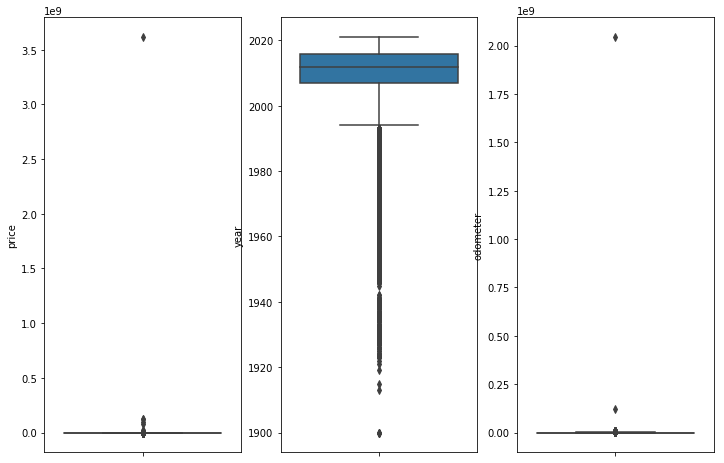

In [56]:
# boxplots
fig, axs = plt.subplots(ncols=3, figsize=(12,8))
sns.boxplot(y=car_df['price'], ax=axs[0])
sns.boxplot(y=car_df['year'], ax=axs[1])
sns.boxplot(y=car_df['odometer'], ax=axs[2])
plt.show()

Price

In [58]:
#remove extreme outliers for price and entries that seem to be dummy prices
car_df=car_df[car_df['price'] < 4000000] 
car_df = car_df.drop(car_df[(car_df.price == 1111111) | (car_df.price == 123456) | (car_df.price == 9999999)].index)

Year

In [19]:
a = car_df['year'].value_counts() / len(car_df) * 100
a=pd.DataFrame(a).reset_index()
a.columns=['year','percent']
car_df=pd.merge(car_df,a,on='year')
car_df= car_df[car_df['percent']>0.05]
car_df['percent'].describe()

count    263493.000000
mean          5.074097
std           2.146217
min           0.050514
25%           3.933306
50%           5.006917
75%           6.902323
max           7.790842
Name: percent, dtype: float64

Odometer

In [73]:
car_df = car_df[car_df['odometer'] < 1000000]

In [77]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199915 entries, 0 to 458211
Data columns (total 22 columns):
price               199915 non-null int64
year                199915 non-null float64
manufacturer        199915 non-null object
model               199915 non-null object
condition           199915 non-null object
cylinders           199915 non-null int64
fuel                199915 non-null object
odometer            199915 non-null float64
title_status        199915 non-null object
transmission        199915 non-null object
drive               199915 non-null object
type                183403 non-null object
paint_color         199915 non-null object
image_url           199915 non-null object
state               199915 non-null object
lat                 198227 non-null float64
long                198234 non-null float64
posting_date        199915 non-null datetime64[ns]
condition_new       199915 non-null object
transmission_new    199915 non-null object
price_range$       

### Other cleanup

After the merge with the Dept. of Transportation data, the cyclinders were repeated in different formats.  This column was convertedto an int. 

In [79]:
## fill null with Z and remove later
car_df['cylinders'] = car_df['cylinders'].fillna('Z')
car_df['cylinders'].unique()

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([ 8,  4,  6, 10,  5,  3,  2, 12,  1], dtype=int64)

In [80]:
# transform cylinders to integer format
car_df.drop(car_df[car_df['cylinders']=='Z'].index,inplace=True)
car_df.drop(car_df[car_df['cylinders']=='other'].index,inplace=True)
car_df['cylinders'] = car_df['cylinders'].astype('int64')

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\pandas\core\ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

The Harley-Davidsons were removed since they are motorcycles and this study is focused on cars.  Morgans were removed as well.

In [81]:
# drop "harley-davidson" and "morgan"
car_df = car_df.drop(car_df[(car_df.manufacturer == "harley-davidson") | (car_df.manufacturer == "morgan")].index)

Converted posting date to a datetime object

In [82]:
#convert posting_date to datetime object
car_df['posting_date'] = car_df['posting_date'].astype('datetime64[ns]')

### One Hot Encoding

In [ ]:
car_df2=pd.get_dummies(car_df1[[ 'price', 'year', 'manufacturer', 'model', 'condition_new',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive',
       'size', 'type', 'paint_color', 'cylinders']])

### Simple Statistics
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 

### Visualize Attributes
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

### Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

### Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

### New Features
Are there other features that could be added to the data or created from existing features? Which ones?
* Age in years

In [78]:
car_df['car_Age_in_yrs'] = car_df['posting_date'].dt.year - car_df['year']

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Exceptional Work
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

Plots

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


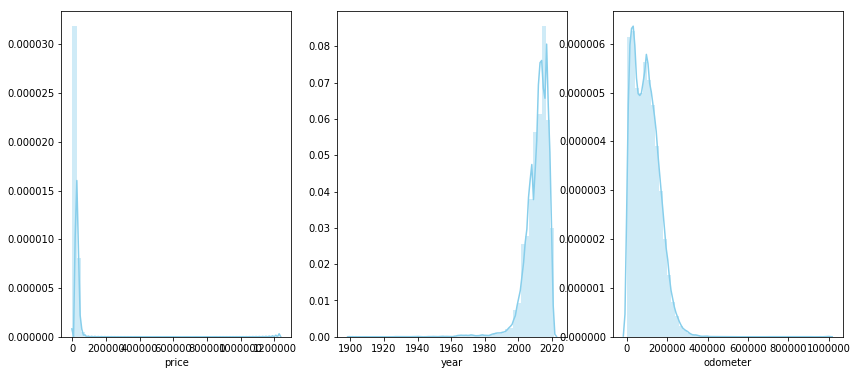

In [83]:
#histograms
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.distplot(car_df['price'] , color="skyblue", ax=axes[0])
sns.distplot(car_df['year'] , color="skyblue", ax=axes[1])
sns.distplot(car_df['odometer'] , color="skyblue", ax=axes[2])


In [190]:
#breakdown of car condition
car_df.groupby('condition_new')['id'].nunique()

condition
excellent    115201
fair         7740  
good         115681
like new     24551 
new          1428  
salvage      661   
Name: id, dtype: int64

Text(0, 0.5, 'Frequency')

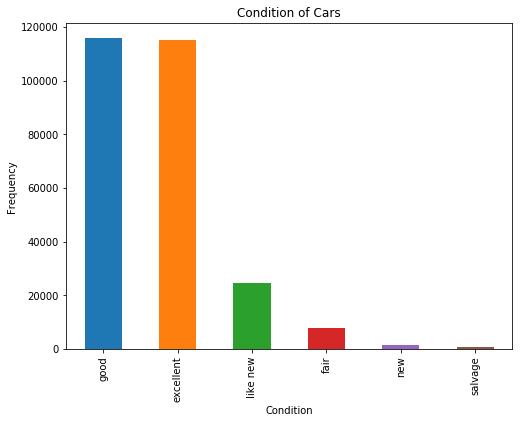

In [191]:
#plot the conditions
ax = car_df['condition'].value_counts().plot(kind='bar',
                                    figsize=(8,6),
                                    title="Condition of Cars")
ax.set_xlabel("Condition")
ax.set_ylabel("Frequency")

In [194]:
#odometer
car_df['odometer'].describe()

count    4.029010e+05
mean     1.016679e+05
std      3.228658e+06
min      0.000000e+00
25%      4.087700e+04
50%      8.764100e+04
75%      1.340000e+05
max      2.043756e+09
Name: odometer, dtype: float64

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


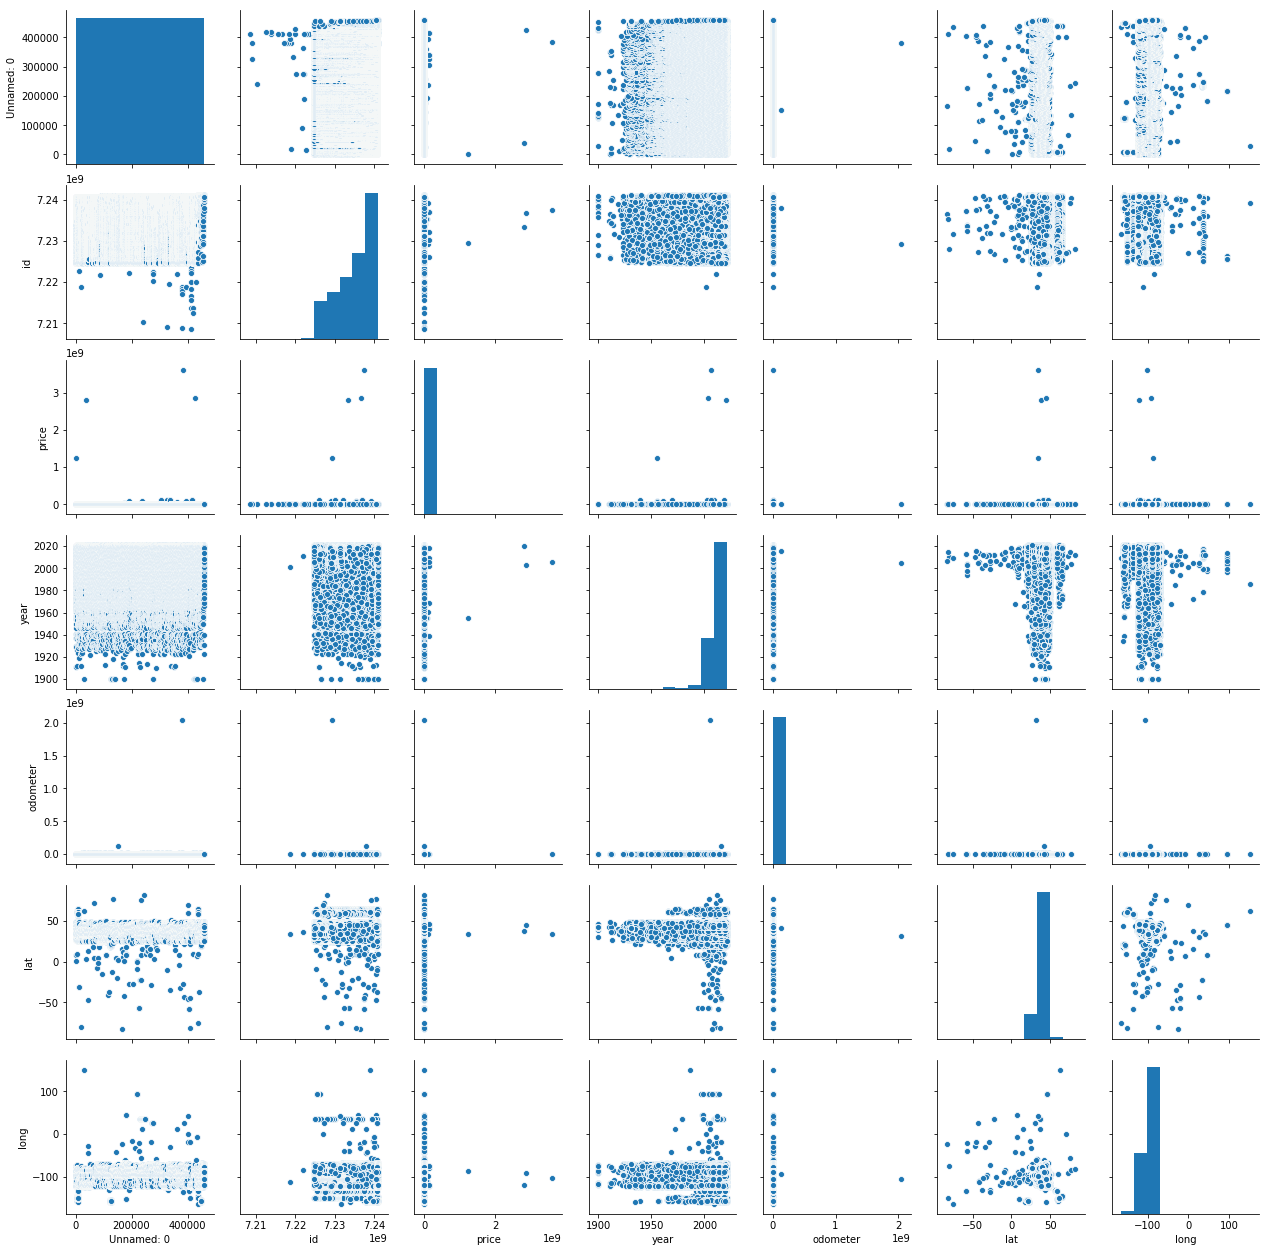

In [16]:
# Basic correlogram
sns.pairplot(car_df)
#sns.plt.show()